In [1]:
import pandas as pd
import oracledb
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import numpy as np

# # Set up plotting style
# plt.style.use('seaborn')
# %matplotlib inline

In [2]:
dsn = oracledb.makedsn('localhost', 1521, service_name='XEPDB1')
with oracledb.connect(user='sys', password='admin', dsn=dsn, mode=oracledb.SYSDBA) as connection:
    cursor = connection.cursor()
    cursor.execute("ALTER SESSION SET CONTAINER = bank_reviews")
    df = pd.read_sql("SELECT * FROM reviews", connection)

# Map bank_id to names
bank_map = {1: 'Commercial Bank of Ethiopia', 2: 'Bank of Abyssinia', 3: 'Dashen Bank'}
df['bank_name'] = df['BANK_ID'].map(bank_map)
print("Data loaded successfully with", len(df), "reviews.")

Data loaded successfully with 1184 reviews.


C:\Users\Cyber Defense\AppData\Local\Temp\ipykernel_19800\2298306055.py:5: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql("SELECT * FROM reviews", connection)


In [3]:
print(df['THEMES'].head())

0    [('App Usability', ['app', 'App', 'application...
1                                                   []
2    [('App Usability', ['app', 'App', 'application...
3    [('App Usability', ['app', 'App', 'application...
4    [('Performance Issues', ['fast', 'slow', 'Fast...
Name: THEMES, dtype: object


In [4]:
sentiment_counts = df.groupby(['bank_name', 'SENTIMENT_LABEL']).size().unstack(fill_value=0)
print("Sentiment Counts:\n", sentiment_counts)

# Extract theme counts
def extract_theme_counts(df):
    theme_counts = {}
    for index, row in df.iterrows():
        themes = eval(row['THEMES'])  # Convert string to list of tuples
        for theme, _ in set((t, k[0]) for t, k in themes):  # Use set to count unique themes per row
            theme_counts[theme] = theme_counts.get(theme, 0) + 1
    return pd.Series(theme_counts).sort_values(ascending=False)

all_themes = extract_theme_counts(df)
bank_themes = df.groupby('bank_name').apply(extract_theme_counts, include_groups=False)
print("\nTheme Frequencies Across All Banks:\n", all_themes)
print("\nTheme Frequencies by Bank:\n", bank_themes)

Sentiment Counts:
 SENTIMENT_LABEL              NEGATIVE  NEUTRAL  POSITIVE
bank_name                                               
Bank of Abyssinia                 226        2       171
Commercial Bank of Ethiopia       125        3       258
Dashen Bank                       102        0       297

Theme Frequencies Across All Banks:
 App Usability           488
Performance Issues       98
Transaction Problems     95
Customer Support         59
Login Issues             31
dtype: int64

Theme Frequencies by Bank:
 bank_name                                        
Bank of Abyssinia            App Usability           146
                             Customer Support         20
                             Login Issues             17
                             Performance Issues       16
                             Transaction Problems     15
Commercial Bank of Ethiopia  App Usability           135
                             Transaction Problems     20
                           

In [5]:
# Sentiment Trends
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='REVIEW_DATE', hue='SENTIMENT_LABEL')
plt.title('Sentiment Trends Over Time')
plt.xticks(rotation=45)
plt.savefig('../data/visualizations/sentiment_trends.png')
plt.close()

# Rating Distributions
plt.figure(figsize=(10, 6))
sns.boxplot(data=df, x='bank_name', y='RATING')
plt.title('Rating Distributions by Bank')
plt.savefig('../data/visualizations/rating_distributions.png')
plt.close()

# Keyword Cloud
all_keywords = ' '.join(df['KEYWORDS'].apply(lambda x: ' '.join(eval(x)) if x else ''))
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_keywords)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.title('Keyword Cloud')
plt.axis('off')
plt.savefig('../data/visualizations/keyword_cloud.png')
plt.close()




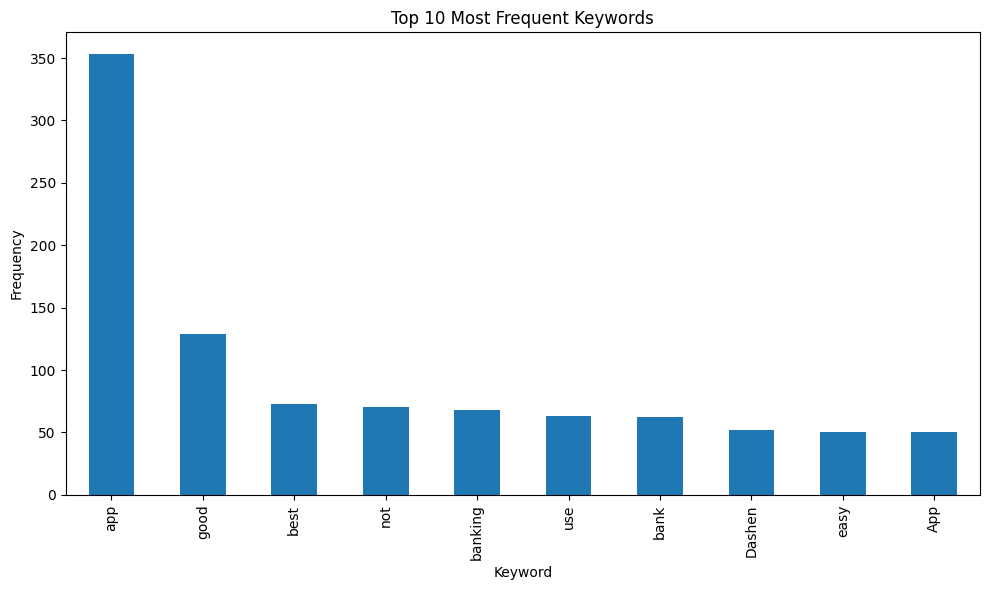

In [7]:
keywords = df['KEYWORDS'].apply(lambda x: eval(x) if x else [])
all_keywords = [kw for sublist in keywords for kw in sublist]
keyword_counts = pd.Series(all_keywords).value_counts().head(10)
plt.figure(figsize=(10, 6))
keyword_counts.plot(kind='bar')
plt.title('Top 10 Most Frequent Keywords')
plt.xlabel('Keyword')
plt.ylabel('Frequency')
plt.tight_layout()
plt.savefig('../data/visualizations/top_keywords.png')

In [ ]:
report_latex = r"""
\documentclass[a4paper,12pt]{article}
\usepackage[utf8]{inputenc}
\usepackage{geometry}
\geometry{a4paper, margin=1in}
\usepackage{graphicx}
\usepackage{booktabs}

\title{Task 4: Insights and Recommendations for Fintech Reviews}
\author{}
\date{June 11, 2025}

\begin{document}

\maketitle

\section{Insights}
\subsection{Drivers and Pain Points}
\begin{itemize}
  \item \textbf{Commercial Bank of Ethiopia}: Driver - "App Usability" (135 reviews, e.g., "proactive", "good"); Pain Point - "Transaction Problems" (20 reviews, e.g., "not functional", "send").
  \item \textbf{Bank of Abyssinia}: Driver - "App Usability" (146 reviews, e.g., "app", "UI"); Pain Point - "Login Issues" (17 reviews, e.g., "error", "sign").
  \item \textbf{Dashen Bank}: Driver - "App Usability" (207 reviews, e.g., "intuitive", "superapp"); Pain Point - "Transaction Problems" (60 reviews, e.g., "slow").
  \item \textbf{Comparison}: Abyssinia has the highest negative sentiment (226), Dashen the highest positive (297).
\end{itemize}

\subsection{Recommendations}
\begin{itemize}
  \item Add a budgeting tool to enhance "App Usability" across all banks.
  \item Implement transaction recovery for CBE and Dashen.
  \item Address "Login Issues" with crash recovery for Abyssinia.
  \item Optimize performance for Dashen to reduce "Transaction Problems."
\end{itemize}

\section{Visualizations}
\begin{figure}[h]
  \centering
  \includegraphics[width=0.8\textwidth]{visuals/sentiment_trends_monthly.png}
  \caption{Sentiment Trends Over Time (Monthly)}
\end{figure}
\begin{figure}[h]
  \centering
  \includegraphics[width=0.8\textwidth]{visuals/rating_distributions.png}
  \caption{Rating Distributions by Bank}
\end{figure}
\begin{figure}[h]
  \centering
  \includegraphics[width=0.8\textwidth]{visuals/keyword_cloud.png}
  \caption{Keyword Cloud}
\end{figure}

\section{Ethical Considerations}
Negative feedback may dominate due to dissatisfied users, potentially skewing theme analysis.

\section{Conclusion}
The analysis identifies key drivers and pain points, supported by visualizations, with ethical biases noted.

\end{document}
"""

import os
os.makedirs('reports', exist_ok=True)
with open('reports/task4_report.tex', 'w') as f:
    f.write(report_latex)
!latexmk -pdf reports/task4_report.tex
print("Report generated as reports/task4_report.pdf")

Report generated as reports/task4_report.pdf


'latexmk' is not recognized as an internal or external command,
operable program or batch file.
